In [17]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Tickers and date range for data accessing

In [18]:
tickers = ["WBD","BCC","SOLV","PFE","OXY","PG","T","TJX","MMM","BA","O","KMI","CSCO","CVS","DIS","MA","RTX","AXP","BX"]

years_delta = 1
end_date = datetime.today()
start_date = end_date - timedelta(days =  years_delta * 365)

## Downloding the adjusted close price
> This is done as the `adj Close` is relatively more accurate when it comes to close prices as it includes dividends and stock splits.
> An optimal portfolio would underweigh a portfolio that pays more dividends as it wouldn't be refleced if you use `close price`

In [19]:
adj_close_df = pd.DataFrame()

for scrip in tickers:
    data = yf.download(scrip, start = start_date, end = end_date)
    adj_close_df[scrip] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [20]:
adj_close_df

,WBD,BCC,SOLV,PFE,OXY,PG,T,TJX,MMM,BA,O,KMI,CSCO,CVS,DIS,MA,RTX,AXP,BX
Date,,,,,,,,,,,,,,,,,,,
2023-10-12,10.3200,85.408211,NaN,31.086361,62.295570,139.778595,13.607358,87.655937,71.200050,191.300003,47.501167,15.881478,52.152412,68.245262,83.689888,397.600098,71.472992,149.490036,101.879166
2023-10-13,10.3700,85.892975,NaN,30.321482,63.428757,141.114761,13.522607,87.340477,70.928123,184.910004,47.794037,16.069317,52.074936,68.841873,83.689888,395.740875,71.424232,149.312164,100.849304
2023-10-16,10.9000,86.002716,NaN,31.416870,64.414131,142.460648,13.569691,88.405128,71.935883,184.929993,47.935749,16.228973,52.452641,68.793762,85.039246,398.852844,72.136040,150.982162,101.568253
2023-10-17,10.9200,87.255760,NaN,30.925837,64.571785,142.645950,13.729777,89.321915,72.423782,185.600006,48.153034,16.275932,52.239578,69.294151,85.525406,399.459351,72.048279,152.563232,102.335793
2023-10-18,10.5800,85.499672,NaN,29.660473,65.527596,146.322815,13.484939,89.164185,70.704163,185.690002,47.151615,16.097490,52.074936,68.408844,84.017303,390.948517,72.389557,149.737076,99.391937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-07,7.7200,141.270004,66.290001,29.200001,55.910000,167.119995,21.503902,112.129997,134.850006,155.910004,61.669998,23.580000,52.509998,65.250000,92.389999,490.647644,125.050003,273.790009,149.070007
2024-10-08,7.7200,142.020004,67.129997,29.180000,54.320000,168.160004,21.582888,113.449997,134.690002,154.649994,61.509998,23.320000,52.730000,65.900002,92.510002,496.399994,123.500000,269.109985,149.440002
2024-10-09,7.7300,142.389999,69.180000,30.190001,53.900002,169.270004,21.652000,113.980003,135.009995,149.369995,61.810001,23.480000,53.560001,65.970001,93.599998,499.950012,123.949997,271.420013,148.419998


## Calculate the Lognormal returns for each scrip
> The `shift` operator help you take in the value after shifting the index from 1 row down. That is, the first index would be
> from the date 15-10-2019 after shifting instead of 14-10-2019

In [21]:
lognormal_rets = np.log(adj_close_df/adj_close_df.shift(1) ) 

In [22]:
#drop the missing values 
lognormal_rets = lognormal_rets.dropna()

In [23]:
lognormal_rets

,WBD,BCC,SOLV,PFE,OXY,PG,T,TJX,MMM,BA,O,KMI,CSCO,CVS,DIS,MA,RTX,AXP,BX
Date,,,,,,,,,,,,,,,,,,,
2024-04-02,-0.035904,-0.026500,-0.032356,-0.006152,0.013170,-0.000062,0.001142,-0.002309,-0.012630,-0.007734,-0.011098,0.000543,-0.013682,-0.074882,0.010559,0.002151,0.008049,-0.009180,-0.036687
2024-04-03,0.029055,0.013073,-0.046036,-0.012051,0.006668,-0.027913,0.005124,-0.022263,0.003763,-0.016731,-0.001893,0.007033,-0.004504,0.010511,-0.031764,-0.004201,-0.010199,0.004866,0.002056
2024-04-04,-0.033783,-0.011731,0.047530,-0.021163,-0.001182,-0.004493,-0.002274,-0.015853,-0.028849,-0.008854,-0.002847,-0.006490,-0.013010,-0.009428,-0.016013,-0.016153,0.017881,-0.028463,-0.004434
2024-04-05,-0.014320,0.018862,0.044659,0.000375,0.023672,0.004173,-0.008574,0.011010,0.005397,-0.000819,0.007384,0.001626,0.009104,0.009160,0.010957,0.015588,0.023683,0.012985,0.012382
2024-04-08,0.023754,0.002891,-0.044510,-0.003005,-0.007537,-0.000384,-0.009807,-0.006009,0.009838,-0.008665,0.011814,-0.005432,-0.006406,-0.001879,-0.008739,0.004941,0.001867,0.007390,0.013546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-04,0.005155,0.004401,0.007111,0.008433,0.017549,-0.007316,-0.006369,-0.003221,0.003629,0.029329,-0.006270,0.011497,0.006085,0.026195,0.016104,0.005500,0.009977,0.029716,0.004751
2024-10-07,-0.007742,0.016919,-0.021638,0.021462,0.002687,-0.010476,-0.005951,-0.022574,-0.003110,0.005854,-0.005498,-0.001695,-0.004560,0.010167,-0.029436,-0.012943,0.001120,-0.007931,-0.018938
2024-10-08,0.000000,0.005295,0.012592,-0.000685,-0.028851,0.006204,0.003666,0.011703,-0.001187,-0.008114,-0.002598,-0.011088,0.004181,0.009912,0.001298,0.011656,-0.012473,-0.017241,0.002479


## Covarience matrix
> The cov matrix helps you measure the total risk of the portfolio. Each asset has a certain correlation and covarience with
> each other. So, we can std dev in the most optimal way possible using this.


In [24]:
# multiply by 252 to convert the result from daily to annualized 
cov_matrix = lognormal_rets.cov() * 252 
cov_matrix

,WBD,BCC,SOLV,PFE,OXY,PG,T,TJX,MMM,BA,O,KMI,CSCO,CVS,DIS,MA,RTX,AXP,BX
WBD,0.235883,0.073046,0.020705,0.037479,0.008388,-0.001743,0.010401,0.014646,0.032188,0.051012,0.018758,0.023664,0.029264,0.023816,0.031213,0.009332,0.005813,0.033223,0.052698
BCC,0.073046,0.164038,0.025702,0.021395,0.023623,-0.013464,-0.001362,0.022012,0.036361,0.042484,0.012131,0.016965,0.021185,0.032963,0.034324,0.011799,0.018496,0.031735,0.070151
SOLV,0.020705,0.025702,0.122262,0.012304,0.010743,0.000362,0.012391,0.005860,0.007798,0.022520,0.004439,0.007370,0.016708,0.018681,0.013768,0.008316,0.011465,0.014590,0.018450
PFE,0.037479,0.021395,0.012304,0.055564,-0.000167,0.004762,0.015087,0.010899,0.026529,0.022625,0.012703,0.007847,0.014755,-0.000524,0.012634,0.000949,0.005137,0.010206,0.018283
OXY,0.008388,0.023623,0.010743,-0.000167,0.049932,-0.005760,0.003848,0.000216,0.001941,0.019727,0.000748,0.020359,0.011280,0.015500,0.009380,0.009460,0.009519,0.020847,0.018343
PG,-0.001743,-0.013464,0.000362,0.004762,-0.005760,0.024540,0.009648,0.002921,0.007146,-0.006279,0.009036,0.000267,0.002057,0.005750,0.000515,0.003974,-0.001699,-0.006134,-0.001831
T,0.010401,-0.001362,0.012391,0.015087,0.003848,0.009648,0.036097,0.001567,-0.003177,-0.003569,0.009461,0.004197,0.006337,0.013826,0.003941,0.003134,0.002149,0.000526,-0.002086
TJX,0.014646,0.022012,0.005860,0.010899,0.000216,0.002921,0.001567,0.034407,0.007168,0.014268,0.003939,0.002812,0.012055,0.010301,0.015111,0.008687,0.002983,0.008073,0.016295
MMM,0.032188,0.036361,0.007798,0.026529,0.001941,0.007146,-0.003177,0.007168,0.113260,0.023957,0.008560,0.010330,0.013063,0.024700,0.014856,0.012063,0.003572,0.015950,0.019828
BA,0.051012,0.042484,0.022520,0.022625,0.019727,-0.006279,-0.003569,0.014268,0.023957,0.115739,0.005505,0.012902,0.018428,0.011780,0.021343,0.008939,0.022015,0.031602,0.032463


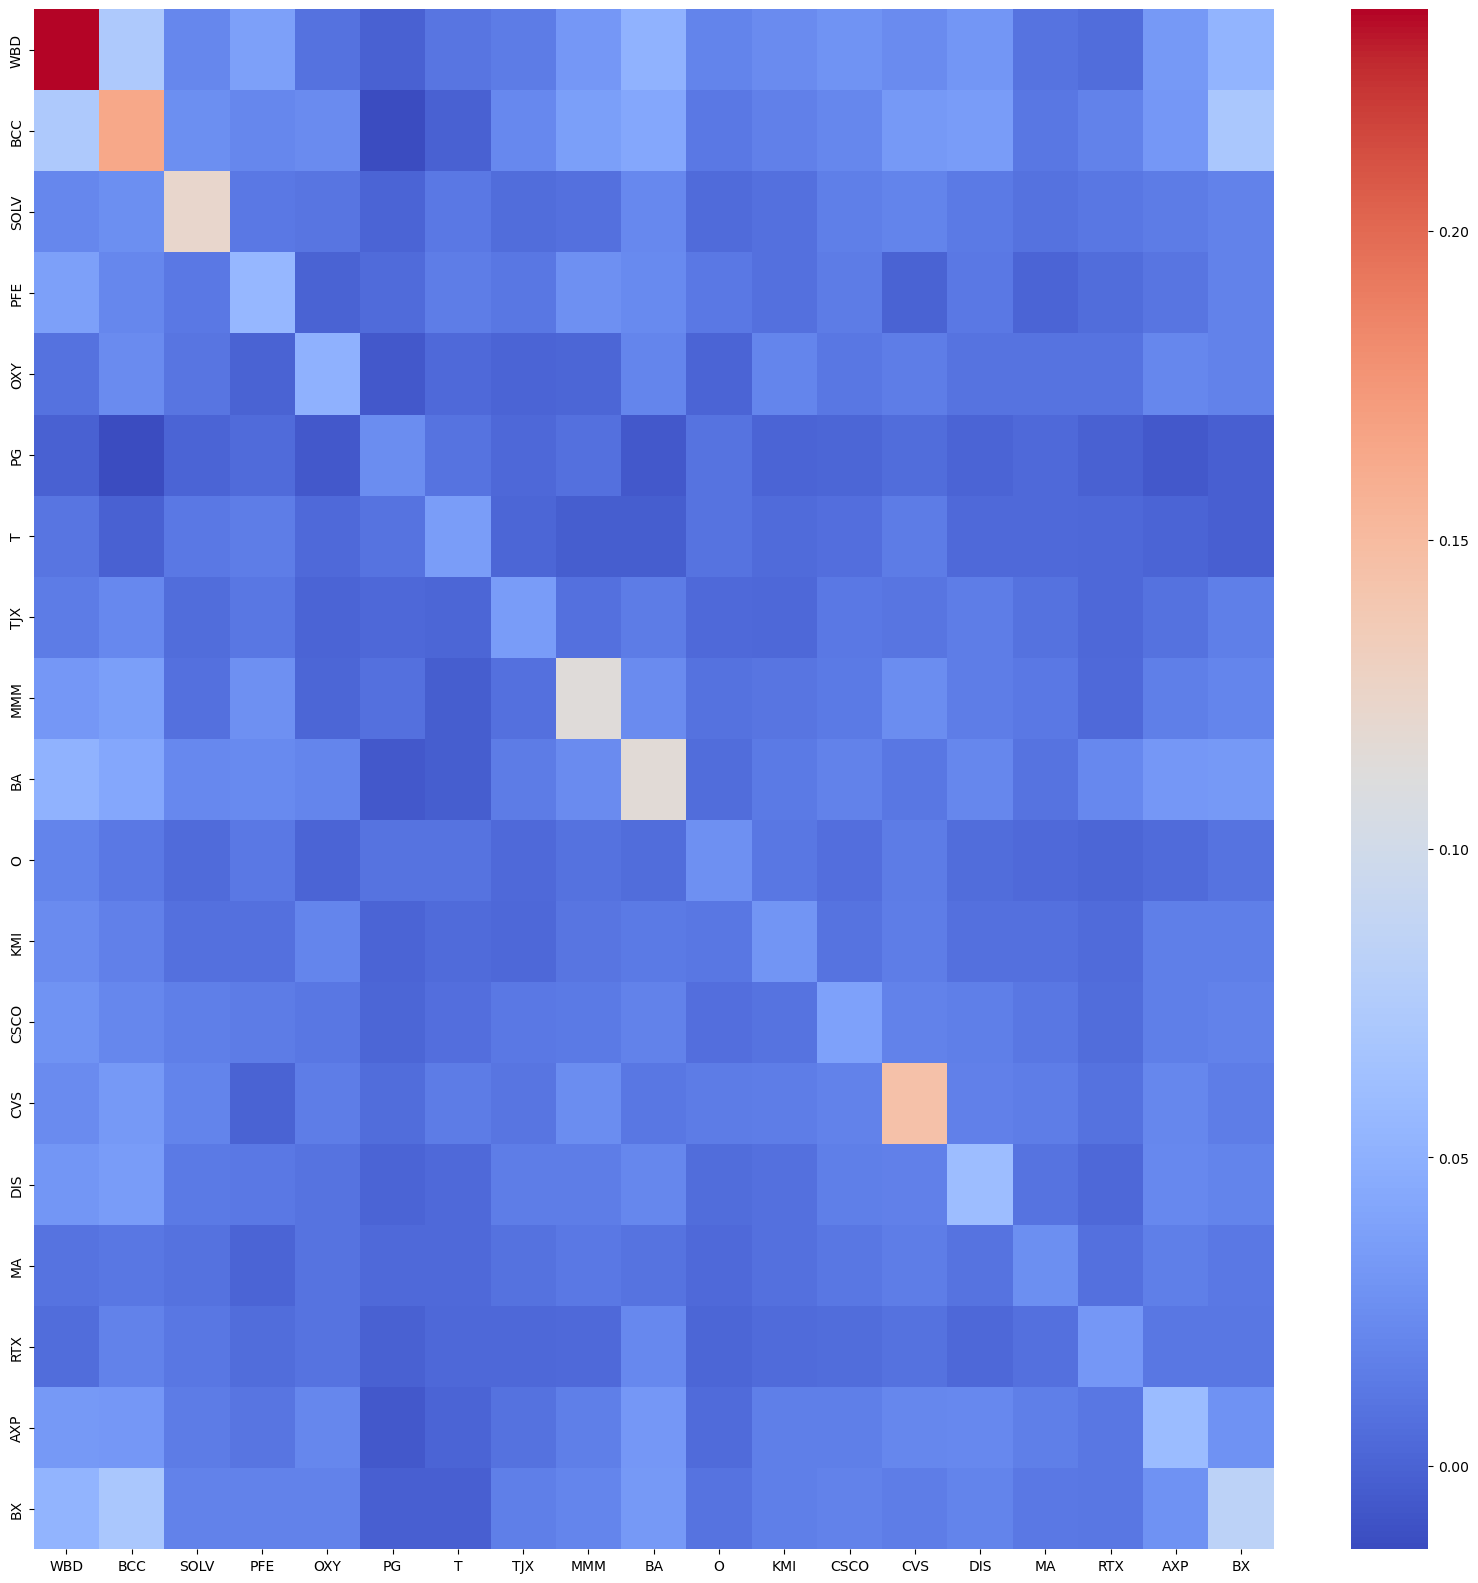

In [25]:
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(cov_matrix, cmap='coolwarm')
plt.show()

## Portfolio Performance 
> Standard deviation

> Expected returns

> Sharpe ratio

In [26]:
def variance(weights, cov):
    return weights.T @ cov @ weights

def std_dev(weights, cov):
    return np.sqrt(variance(weights,cov))

## Expected returns from historical values 
> this should be optimized 

In [27]:

def exp_returns(weights, log_returns):
    # Check if the weights sum to 1, normalize if necessary
    if np.sum(weights) != 1:
        weights = weights / np.sum(weights)

    # Calculate the mean of the log returns
    mean_log_returns = log_returns.mean()

    # Compute expected returns using matrix multiplication
    expected_return = np.dot(weights, mean_log_returns) * 252  # Annualize the returns (assuming 252 trading days)

    return expected_return

## Sharpe Ratio 
> SR = ( portfolio returns - risk free rate ) / std dev

In [28]:
# risk free rate is usually around 3 % 

def sharpe_ratio(weights, log_returns, cov, risk_free_rate):
    return ( exp_returns(weights, log_returns) - risk_free_rate ) / std_dev( weights, cov )

In [29]:
# negative sharpe ratio
# this functoins is to minimize the value

def neg_sharpe_ratio(weights, log_returns, cov, risk_free_rate):
    return -1 * ( exp_returns(weights, log_returns) - risk_free_rate ) / std_dev( weights, cov )

## Constraints and bounds
conditions that must be met by the solution during optimization. 
> Sum of all portfolio weights must equal to 1.

> type is set to `equqlity` => equality,

> Fun is set to `checksum' => ensures if the portfolio weights sum upto 1

> Bounds are the limits on variables during optimization. Here, the variables are portfolio weights, and each should be
> between 0 and 1

In [42]:
constraints = { 'type' : 'eq', 'fun' : lambda weights: np.sum( weights ) - 1 }
# The max size of a position could only be 40% and the min could only be 0%
# no negatives as we are not going short on assets. We are only on the buy side
bounds = [ (0, 0.15) for each in range( len( tickers ) ) ] 

In [43]:
# setting initial weights
init_weights = np.array( [ 1 / len(tickers) ] * len(tickers) )
init_weights

array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158])

## Optimization
> SLSQP, AKA sequential least square quadratic programming, which is a numerical optimization technique suitable for solving nonlinear optimization problems with constraints

In [44]:
risk_free_rate = 0.0409

optimized_res = minimize(
    neg_sharpe_ratio, init_weights, args = ( lognormal_rets, cov_matrix, risk_free_rate), 
    method = 'SLSQP',
    constraints = constraints,
    bounds = bounds
)

In [45]:
# accesses the optimal weights from res
optimal_weights = optimized_res.x 
optimal_weights

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05807743, 0.15      , 0.15      , 0.13538508, 0.        ,
       0.15      , 0.15      , 0.        , 0.        , 0.        ,
       0.        , 0.15      , 0.05653749, 0.        ])

In [46]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = exp_returns(optimal_weights, lognormal_rets)
optimal_portfolio_volatility = std_dev(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, lognormal_rets, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
WBD: 0.0000
BCC: 0.0000
SOLV: 0.0000
PFE: 0.0000
OXY: 0.0000
PG: 0.0581
T: 0.1500
TJX: 0.1500
MMM: 0.1354
BA: 0.0000
O: 0.1500
KMI: 0.1500
CSCO: 0.0000
CVS: 0.0000
DIS: 0.0000
MA: 0.0000
RTX: 0.1500
AXP: 0.0565
BX: 0.0000
Expected Annual Return: 0.4163
Expected Volatility: 0.1018
Sharpe Ratio: 3.6868


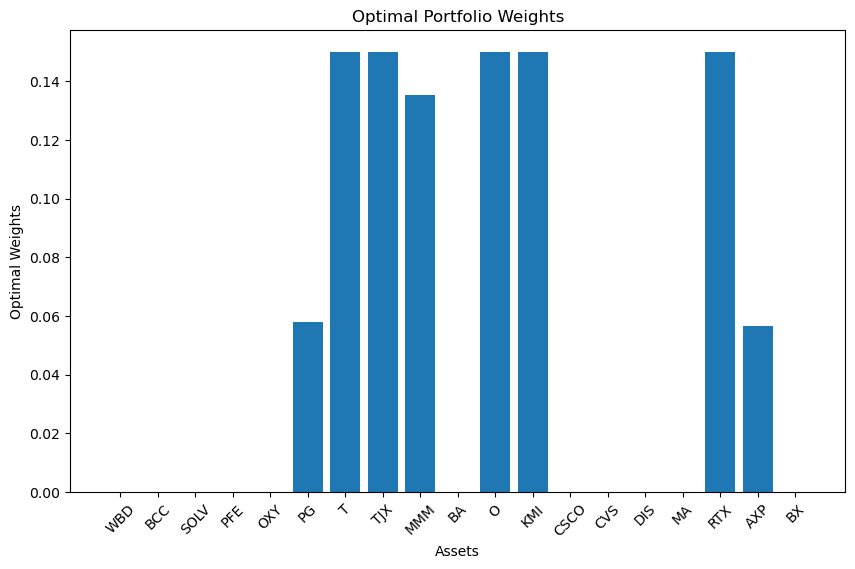

In [47]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')
# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)
plt.show()